In [256]:
import wrds
db = wrds.Connection(wrds_username='chesterqi')

Loading library list...
Done


In [257]:
import wrds
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt   
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy
import datetime
from scipy.stats import zscore
from sklearn import linear_model
from sklearn.metrics import r2_score
from math import exp

In [258]:
# db_surprise = db.raw_sql(f"""
# select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
# from (
# SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
# ) as a
#  inner join (
# SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
# a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
# FROM ibes.statsum_epsus as a,crsp.msf as b 

# where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
# SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
# )

# ) as b
# on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
# where adjust_shares*adjust_prc>500000
# order by ticker,fpedats,statpers;
# """)


db_surprise = db.raw_sql(f"""
select * from (
SELECT b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr , CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM 
(
select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
from (
SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
) as a
 inner join (
SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
FROM ibes.statsum_epsus as a,crsp.msf as b 

where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
)

) as b
on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
) as b
) as b
where adjust_shares*adjust_prc>500000
""")
lst_surprise = list(db_surprise[db_surprise["fpedats"] > datetime.date(1999,12,31)].sort_values(by = "fpedats")["fpedats"].unique())
df_surprise = pd.DataFrame()
df_surprise10 = pd.DataFrame()
for date in lst_surprise:
    dbs = db.raw_sql(f"""
            select * from (
            SELECT b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr , CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM 
            (
            select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
            from (
            SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
            ) as a
             inner join (
            SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
            a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
            FROM ibes.statsum_epsus as a,crsp.msf as b 

            where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
            SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
            )

            ) as b
            on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
            ) as b
            ) as b
            where adjust_shares*adjust_prc>500000 and b.fpedats = '{date}'
            """)
    dbs.sort_values("surprise",ascending=False, inplace=True)
    dbs = dbs.dropna()
    if dbs.shape[0] < 20:
        pass 
    else:
        df1 = dbs.head(5)
        df2 = dbs.tail(5)
        df3 = dbs.head(10)
        df4 = dbs.tail(10)
        if df_surprise.shape[0] == 0:
            df_surprise = pd.concat([df1,df2])
            df_surprise10 = pd.concat([df3,df4])
        else:
            df_surprise = pd.concat([df_surprise,df1,df2])
            df_surprise10 = pd.concat([df_surprise10,df3,df4])
df_surprise = df_surprise.reset_index(drop=True)
df_surprise10 = df_surprise10.reset_index(drop=True)

In [259]:
# db5 = db.raw_sql(
#     f"""
#     SELECT gvkey,datadate,cusip,bkvlps FROM comp.funda Where datadate > '1998-12-31';
#     """)
# db5 = db5.dropna()

In [343]:
df_m_ret = db.raw_sql('SELECT date, CAST(sum(ret*shrout*prc)/(sum(shrout*prc)+0.000001) as decimal(38, 4))as ret  FROM crsp.msf group by date ;')

In [344]:
df_crspm = db.raw_sql(f"""SELECT cusip,date,prc,bidlo,askhi,vol, ret, bid, ask, spread,CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM crsp.msf where date>'1997-12-31';""")

In [345]:
df_surprise.to_csv("surprise.csv")
df_surprise10.to_csv("surprise10.csv")

In [346]:
beta_lst = []
mon_lst = []
exp_lst = []
m_lst = []
for i in range(df_surprise.shape[0]):
    cus = df_surprise["cusip"].iloc[i]
    date = df_surprise["fpedats"].iloc[i]
    df1 = df_crspm[df_crspm["cusip"] == cus]
    df1 = df1.reset_index(drop = True)
    n1 = df1.index[df1['date']==date][0]
    n2 = df_m_ret.index[df_m_ret['date']==date][0]
    df1_back = df1[n1-5:n1+1]
    ret_lst = df1_back["ret"].to_list()
    dfm_back = df_m_ret[n2-5:n2+1]
    retm_lst = dfm_back["ret"].to_list()
    if len(ret_lst) != len(retm_lst):
        beta_lst.append(np.nan)
        mon_lst.append(np.nan)
        exp_lst.append(np.nan)
        m_lst.append(np.nan)
    else:
        covms = np.cov(retm_lst,ret_lst)[0][1]
        varm = np.cov(retm_lst,ret_lst)[0][0]
        beta = covms/varm
        mon = sum(ret_lst) - sum(retm_lst)
        df1_exp = df1[n1:n1+3]
        ret_lst_exp = df1_exp["ret"].to_list()
        dfm_exp = df_m_ret[n2:n2+3]
        retm_lst_exp = dfm_exp["ret"].to_list()
        exp_ret = sum(ret_lst_exp)
        m_ret  = sum(retm_lst_exp)
        beta_lst.append(beta)
        mon_lst.append(mon)
        exp_lst.append(exp_ret)
        m_lst.append(m_ret)
df_surprise["Beta"] = beta_lst
df_surprise["Mon"] = mon_lst
df_surprise["exp_return"] = exp_lst
df_surprise["market_return"] = m_lst

In [347]:
df_surprise["surprise_percent"] = df_surprise["surprise"]/abs(df_surprise["prc"])

In [348]:
beta_lst10 = []
mon_lst10 = []
exp_lst10 = []
m_lst10 = []
for i in range(df_surprise10.shape[0]):
    cus = df_surprise10["cusip"].iloc[i]
    date = df_surprise10["fpedats"].iloc[i]
    df1 = df_crspm[df_crspm["cusip"] == cus]
    df1 = df1.reset_index(drop = True)
    n1 = df1.index[df1['date']==date][0]
    n2 = df_m_ret.index[df_m_ret['date']==date][0]
    df1_back = df1[n1-5:n1+1]
    ret_lst = df1_back["ret"].to_list()
    dfm_back = df_m_ret[n2-5:n2+1]
    retm_lst = dfm_back["ret"].to_list()
    if len(ret_lst) != len(retm_lst):
        beta_lst10.append(np.nan)
        mon_lst10.append(np.nan)
        exp_lst10.append(np.nan)
        m_lst10.append(np.nan)
    else:
        covms = np.cov(retm_lst,ret_lst)[0][1]
        varm = np.cov(retm_lst,ret_lst)[0][0]
        beta = covms/varm
        mon = sum(ret_lst) - sum(retm_lst)
        df1_exp = df1[n1:n1+3]
        ret_lst_exp = df1_exp["ret"].to_list()
        dfm_exp = df_m_ret[n2:n2+3]
        retm_lst_exp = dfm_exp["ret"].to_list()
        exp_ret = sum(ret_lst_exp)
        m_ret  = sum(retm_lst_exp)
        beta_lst10.append(beta)
        mon_lst10.append(mon)
        exp_lst10.append(exp_ret)
        m_lst10.append(m_ret)
df_surprise10["Beta"] = beta_lst10
df_surprise10["Mon"] = mon_lst10
df_surprise10["exp_return"] = exp_lst10
df_surprise10["market_return"] = m_lst10

In [349]:
df_surprise10["surprise_percent"] = df_surprise10["surprise"]/abs(df_surprise10["prc"])

In [350]:
df_surprise

,ticker,cusip,statpers,measure,numest,medest,meanest,stdev,fpedats,actual,...,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr,Beta,Mon,exp_return,market_return,surprise_percent
0,MND,60659230,1998-08-20,EPS,4.0,0.82,0.84,0.10,2000-01-31,1.770,...,22.5000,1.000000,26796.0,26796.0,1.0,-1.340587,0.045170,0.030414,0.1629,0.041333
1,TWE,87236210,2000-01-20,EPS,8.0,0.07,0.07,0.01,2000-01-31,0.170,...,13.4375,1.000000,376419.0,376419.0,1.0,1.411412,-0.400837,0.542372,0.1629,0.007442
2,CMOS,22530210,2000-01-20,EPS,8.0,0.25,0.26,0.01,2000-01-31,0.355,...,42.4375,2.000000,22517.0,45034.0,2.0,2.765252,0.594627,0.490194,0.1629,0.001119
3,AT1,00846U10,2000-01-20,EPS,9.0,0.22,0.22,0.02,2000-01-31,0.300,...,45.1880,1.464715,452000.0,452000.0,1.0,NaN,NaN,NaN,NaN,0.001209
4,ZAL,98885810,2000-01-20,EPS,15.0,1.14,1.10,0.05,2000-01-31,1.165,...,17.8750,2.000000,35251.0,70502.0,2.0,1.070370,-0.277337,0.045618,0.1629,0.001818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,SONO,83549510,2020-06-18,EPS,8.0,0.78,0.78,0.03,2020-06-30,0.790,...,52.2900,1.000000,100329.0,100329.0,1.0,0.648333,-0.171843,0.031989,0.1754,0.000191
886,BMI,05652510,2020-06-18,EPS,4.0,0.34,0.34,0.04,2020-06-30,0.330,...,62.9200,1.000000,29117.0,29117.0,1.0,0.666130,-0.051687,0.011525,0.1754,-0.000159
887,SCH,80851310,2020-06-18,EPS,14.0,0.50,0.51,0.06,2020-06-30,0.480,...,33.7400,1.000000,1287413.0,1287413.0,1.0,0.988172,-0.343249,-0.000691,0.1754,-0.000889
888,NOB,94974610,2020-06-18,EPS,23.0,0.19,0.17,0.25,2020-06-30,-0.660,...,25.6000,1.000000,4099998.0,4099998.0,1.0,1.040580,-0.678643,-0.085623,0.1754,-0.032422


In [351]:
df_surprise10

,ticker,cusip,statpers,measure,numest,medest,meanest,stdev,fpedats,actual,...,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr,Beta,Mon,exp_return,market_return,surprise_percent
0,MND,60659230,1998-08-20,EPS,4.0,0.82,0.84,0.10,2000-01-31,1.770,...,22.5000,1.000000,26796.0,26796.0,1.0,-1.340587,0.045170,0.030414,0.1629,0.041333
1,TWE,87236210,2000-01-20,EPS,8.0,0.07,0.07,0.01,2000-01-31,0.170,...,13.4375,1.000000,376419.0,376419.0,1.0,1.411412,-0.400837,0.542372,0.1629,0.007442
2,CMOS,22530210,2000-01-20,EPS,8.0,0.25,0.26,0.01,2000-01-31,0.355,...,42.4375,2.000000,22517.0,45034.0,2.0,2.765252,0.594627,0.490194,0.1629,0.001119
3,AT1,00846U10,2000-01-20,EPS,9.0,0.22,0.22,0.02,2000-01-31,0.300,...,45.1880,1.464715,452000.0,452000.0,1.0,NaN,NaN,NaN,NaN,0.001209
4,ZAL,98885810,2000-01-20,EPS,15.0,1.14,1.10,0.05,2000-01-31,1.165,...,17.8750,2.000000,35251.0,70502.0,2.0,1.070370,-0.277337,0.045618,0.1629,0.001818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,SONO,83549510,2020-06-18,EPS,8.0,0.78,0.78,0.03,2020-06-30,0.790,...,52.2900,1.000000,100329.0,100329.0,1.0,0.648333,-0.171843,0.031989,0.1754,0.000191
1776,BMI,05652510,2020-06-18,EPS,4.0,0.34,0.34,0.04,2020-06-30,0.330,...,62.9200,1.000000,29117.0,29117.0,1.0,0.666130,-0.051687,0.011525,0.1754,-0.000159
1777,SCH,80851310,2020-06-18,EPS,14.0,0.50,0.51,0.06,2020-06-30,0.480,...,33.7400,1.000000,1287413.0,1287413.0,1.0,0.988172,-0.343249,-0.000691,0.1754,-0.000889
1778,NOB,94974610,2020-06-18,EPS,23.0,0.19,0.17,0.25,2020-06-30,-0.660,...,25.6000,1.000000,4099998.0,4099998.0,1.0,1.040580,-0.678643,-0.085623,0.1754,-0.032422


In [352]:
df_test = df_surprise.dropna()
df_test10 = df_surprise10.dropna()

In [353]:
df_train1 = df_test[df_test["fpedats"] < datetime.date(2005,1,2)]
df_train2 = df_test[(df_test["fpedats"] > datetime.date(2005,1,2)) & (df_test["fpedats"] < datetime.date(2007,1,2))]
df_train = pd.concat([df_train1,df_train2])
df10_train1 = df_test10[df_test10["fpedats"] < datetime.date(2005,1,2)]
df10_train2 = df_test10[(df_test10["fpedats"] > datetime.date(2005,1,2)) & (df_test10["fpedats"] < datetime.date(2007,1,2))]
df10_train = pd.concat([df10_train1,df10_train2])

In [354]:
X1 = df_train[['surprise',"Beta","Mon"]]
Y1 = df_train["exp_return"]
res1 = sm.OLS(Y1,X1).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             exp_return   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              5.071
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                     0.00184
Time:                        13:35:03   Log-Likelihood:                         -69.046
No. Observations:                 433   AIC:                                      144.1
Df Residuals:                     430   BIC:                                      156.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surprise       0.0946      0.027      3.499      0.001       0.041       0.148
Beta           0.0042      0.006      0.734      0.463      -0.007       0.015
Mon            0.0370      0.041      0.897      0.370      -0.044       0.118
==============================================================================
Omnibus:                       69.698   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              845.901
Skew:                          -0.052   Prob(JB):                    2.06e-184
Kurtosis:                       9.847   Cond. No.                         7.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [355]:
X4 = df_train[["surprise","Beta","Mon"]]
Y4 = df_train["exp_return"]
res4 = sm.OLS(Y4,X4).fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             exp_return   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              5.071
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                     0.00184
Time:                        13:35:03   Log-Likelihood:                         -69.046
No. Observations:                 433   AIC:                                      144.1
Df Residuals:                     430   BIC:                                      156.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surprise       0.0946      0.027      3.499      0.001       0.041       0.148
Beta           0.0042      0.006      0.734      0.463      -0.007       0.015
Mon            0.0370      0.041      0.897      0.370      -0.044       0.118
==============================================================================
Omnibus:                       69.698   Durbin-Watson:                   1.401
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              845.901
Skew:                          -0.052   Prob(JB):                    2.06e-184
Kurtosis:                       9.847   Cond. No.                         7.31
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
X1_10 = df10_train[['surprise',"Beta","Mon"]]
Y1_10 = df10_train["exp_return"]
res1_10 = sm.OLS(Y1_10,X1_10).fit()
res1_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             exp_return   R-squared (uncentered):                   0.047
Model:                            OLS   Adj. R-squared (uncentered):              0.044
Method:                 Least Squares   F-statistic:                              14.27
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                    4.37e-09
Time:                        13:35:03   Log-Likelihood:                         -77.960
No. Observations:                 871   AIC:                                      161.9
Df Residuals:                     868   BIC:                                      176.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surprise       0.0988      0.025      4.020      0.000       0.051       0.147
Beta           0.0085      0.004      2.140      0.033       0.001       0.016
Mon            0.1137      0.029      3.955      0.000       0.057       0.170
==============================================================================
Omnibus:                      130.059   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1515.867
Skew:                          -0.196   Prob(JB):                         0.00
Kurtosis:                       9.451   Cond. No.                         7.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [357]:
X2 = df_train['surprise']
Y2 = df_train["exp_return"]
res2 = sm.OLS(Y2,X2).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             exp_return   R-squared (uncentered):                   0.031
Model:                            OLS   Adj. R-squared (uncentered):              0.028
Method:                 Least Squares   F-statistic:                              13.70
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                    0.000243
Time:                        13:35:03   Log-Likelihood:                         -69.816
No. Observations:                 433   AIC:                                      141.6
Df Residuals:                     432   BIC:                                      145.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surprise       0.0991      0.027      3.701      0.000       0.046       0.152
==============================================================================
Omnibus:                       67.335   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              765.439
Skew:                           0.048   Prob(JB):                    6.12e-167
Kurtosis:                       9.513   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [358]:
X2_10 = df10_train['surprise']
Y2_10 = df10_train["exp_return"]
res2_10 = sm.OLS(Y2_10,X2_10).fit()
res2_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             exp_return   R-squared (uncentered):                   0.023
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              20.92
Date:                Thu, 23 Dec 2021   Prob (F-statistic):                    5.49e-06
Time:                        13:35:03   Log-Likelihood:                         -88.586
No. Observations:                 871   AIC:                                      179.2
Df Residuals:                     870   BIC:                                      183.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
surprise       0.1127      0.025      4.574      0.000       0.064       0.161
==============================================================================
Omnibus:                      112.442   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1134.516
Skew:                          -0.012   Prob(JB):                    4.40e-247
Kurtosis:                       8.591   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [359]:
beta = []
r2 = []
for a in range(1, 1000):
    clf = linear_model.Lasso(alpha=a/1000, fit_intercept=False)
    clf.fit(X1, Y1)
    beta.append(clf.coef_)
    r2.append(r2_score(df_train["exp_return"],clf.predict(df_train[['surprise',"Beta","Mon"]])))
print(max(r2))
print(r2.index(max(r2)))
print(beta[r2.index(max(r2))])

0.01866949549270136
0
[0.09139733 0.00424983 0.02866667]


In [360]:
beta10 = []
r210 = []
for a in range(1, 1000):
    clf = linear_model.Lasso(alpha=a/1000, fit_intercept=False)
    clf.fit(X1_10, Y1_10)
    beta10.append(clf.coef_)
    r210.append(r2_score(df10_train["exp_return"],clf.predict(df10_train[['surprise',"Beta","Mon"]])))
print(max(r210))
print(r210.index(max(r210)))
print(beta10[r210.index(max(r210))])

0.017841101443875518
0
[0.09222831 0.00848912 0.1044293 ]


In [361]:
Lasso_params = beta[r2.index(max(r2))]
Lasso_params10 = beta10[r210.index(max(r210))]

In [362]:
res1.params

surprise    0.094638
Beta        0.004206
Mon         0.036966
dtype: float64

In [363]:
res2.params

surprise    0.099133
dtype: float64

In [364]:
df_test["signal1"] = df_test["surprise"] * res2.params[0]
df_test["signal2"] = df_test["surprise"] * res1.params[0] + df_test["Beta"] * res1.params[1] + df_test["Mon"] * res1.params[2]
df_test["signal3"] = df_test["surprise"] * Lasso_params[0] + df_test["Beta"] * Lasso_params[1] + df_test["Mon"] * Lasso_params[2]
df_test10["signal1"] = df_test10["surprise"] * res2_10.params[0]
df_test10["signal2"] = df_test10["surprise"] * res1_10.params[0] + df_test10["Beta"] * res1_10.params[1] + df_test10["Mon"] * res1_10.params[2]
df_test10["signal3"] = df_test10["surprise"] * Lasso_params10[0] + df_test10["Beta"] * Lasso_params10[1] + df_test10["Mon"] * Lasso_params10[2]

C:\Users\chest\AppData\Local\Temp/ipykernel_23444/2100363112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["signal1"] = df_test["surprise"] * res2.params[0]
C:\Users\chest\AppData\Local\Temp/ipykernel_23444/2100363112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["signal2"] = df_test["surprise"] * res1.params[0] + df_test["Beta"] * res1.params[1] + df_test["Mon"] * res1.params[2]
C:\Users\chest\AppData\Local\Temp/ipykernel_23444/2100363112.py:3: SettingWithCopyWarning: 
A value i

In [365]:
# df_test1 = df_test[(df_test["fpedats"] > datetime.date(2007,1,2)) & (df_test["fpedats"] < datetime.date(2009,1,2))]
# df_test2 = df_test[(df_test["fpedats"] > datetime.date(2009,1,2)) & (df_test["fpedats"] < datetime.date(2011,1,2))]
# df_test3 = df_test[(df_test["fpedats"] > datetime.date(2011,1,2)) & (df_test["fpedats"] < datetime.date(2013,1,2))]
# df_test4 = df_test[(df_test["fpedats"] > datetime.date(2013,1,2)) & (df_test["fpedats"] < datetime.date(2015,1,2))]
# df_test5 = df_test[(df_test["fpedats"] > datetime.date(2015,1,2)) & (df_test["fpedats"] < datetime.date(2017,1,2))]
# df_test6 = df_test[(df_test["fpedats"] > datetime.date(2017,1,2)) & (df_test["fpedats"] < datetime.date(2019,1,2))]

In [366]:
df_res = pd.DataFrame()
df_res10 = pd.DataFrame()

In [367]:
res_lst1 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal1"]).sum()/abs(x["signal1"]).sum()))
res_risk_lst1 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal1"]).sum()/abs(x["signal1"]).sum()))
res_lst2 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal2"]).sum()/abs(x["signal2"]).sum()))
res_risk_lst2 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal2"]).sum()/abs(x["signal2"]).sum()))
res_lst3 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal3"]).sum()/abs(x["signal3"]).sum()))
res_risk_lst3 = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal3"]).sum()/abs(x["signal3"]).sum()))
market_lst = list(df_test.groupby(["fpedats"]).apply(lambda x: (x["market_return"].mean())))
df_res["Ret1"] = res_lst1
df_res["Beta1"] = res_risk_lst1
df_res["Ret2"] = res_lst2
df_res["Beta2"] = res_risk_lst2
df_res["Ret3"] = res_lst3
df_res["Beta3"] = res_risk_lst3
df_res["market"] = market_lst
df_res["date"] = df_test["fpedats"].unique()
df_res

,Ret1,Beta1,Ret2,Beta2,Ret3,Beta3,market,date
0,0.090980,-0.691501,0.199831,-0.094688,0.201212,-0.062599,0.1629,2000-01-31
1,0.163978,-0.077741,0.029949,0.059374,0.043044,0.160654,0.1428,2000-02-29
2,-0.192720,-0.649524,-0.389385,0.744231,-0.377432,0.643314,0.0290,2000-03-31
3,0.595646,2.767752,0.694424,4.116619,0.688018,4.025457,0.1728,2000-06-30
4,0.077068,-0.701815,0.036518,0.626859,0.027500,0.705090,0.0636,2000-07-31
...,...,...,...,...,...,...,...,...
84,0.031479,-0.280792,0.050774,-0.002212,0.048828,0.012768,0.0388,2018-11-30
85,0.001145,-0.204205,-0.008665,-0.249997,-0.005198,-0.217244,0.0510,2018-12-31
86,0.018203,-0.225236,0.076967,0.560397,0.079768,0.573823,0.0828,2019-09-30
87,0.022154,0.615885,-0.001897,1.142992,-0.002190,1.153943,-0.0356,2019-12-31


In [368]:
res_lst10 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal1"]).sum()/abs(x["signal1"]).sum()))
res_risk_lst10 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal1"]).sum()/abs(x["signal1"]).sum()))
res_lst20 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal2"]).sum()/abs(x["signal2"]).sum()))
res_risk_lst20 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal2"]).sum()/abs(x["signal2"]).sum()))
res_lst30 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal3"]).sum()/abs(x["signal3"]).sum()))
res_risk_lst30 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["Beta"]*x["signal3"]).sum()/abs(x["signal3"]).sum()))
market_lst0 = list(df_test10.groupby(["fpedats"]).apply(lambda x: (x["market_return"].mean())))
df_res10["Ret1"] = res_lst10
df_res10["Beta1"] = res_risk_lst10
df_res10["Ret2"] = res_lst20
df_res10["Beta2"] = res_risk_lst20
df_res10["Ret3"] = res_lst30
df_res10["Beta3"] = res_risk_lst30
df_res10["market"] = market_lst0
df_res10["date"] = df_test10["fpedats"].unique()
df_res10

,Ret1,Beta1,Ret2,Beta2,Ret3,Beta3,market,date
0,0.110098,-0.554618,0.322898,1.264798,0.325002,1.315829,0.1629,2000-01-31
1,0.183944,0.009831,0.116426,0.671156,0.118580,0.691458,0.1428,2000-02-29
2,-0.092310,-0.515970,-0.327269,1.241839,-0.329893,1.270367,0.0290,2000-03-31
3,0.489765,2.251900,0.563774,3.603380,0.565255,3.663208,0.1728,2000-06-30
4,0.104045,-0.468998,0.061629,1.713112,0.060582,1.793124,0.0636,2000-07-31
...,...,...,...,...,...,...,...,...
84,0.030376,-0.114134,0.047288,0.238490,0.047694,0.278733,0.0388,2018-11-30
85,0.002664,-0.204903,-0.044808,-0.253095,-0.043873,-0.227405,0.0510,2018-12-31
86,0.026599,0.001498,0.114870,1.314857,0.118164,1.362907,0.0828,2019-09-30
87,0.015990,0.684045,-0.063942,1.939386,-0.066638,1.981921,-0.0356,2019-12-31


In [369]:
df_res["Alpha1"] = df_res["Ret1"] - df_res["Beta1"]*df_res["market"]
df_res["Alpha2"] = df_res["Ret2"] - df_res["Beta2"]*df_res["market"]
df_res["Alpha3"] = df_res["Ret3"] - df_res["Beta3"]*df_res["market"]
df_res_new = df_res[df_res["date"]> datetime.date(2007,1,2)]
df_res_old = df_res[df_res["date"]< datetime.date(2007,1,2)]

In [370]:
df_res_new["Alpha1"].mean()

0.048502872018268375

In [371]:
df_res_new["Alpha2"].mean()

0.03138549033964891

In [372]:
df_res_new["Alpha3"].mean()

0.02987463723673607

In [373]:
df_res_old["Alpha1"].mean()

0.060326541681120976

In [374]:
df_res_old["Alpha2"].mean()

0.02770282577630148

In [375]:
df_res_old["Alpha3"].mean()

0.026468482390061943

In [376]:
df_res10["Alpha1"] = df_res10["Ret1"] - df_res10["Beta1"]*df_res10["market"]
df_res10["Alpha2"] = df_res10["Ret2"] - df_res10["Beta2"]*df_res10["market"]
df_res10["Alpha3"] = df_res10["Ret3"] - df_res10["Beta3"]*df_res10["market"]
df_res10_new = df_res10[df_res10["date"]> datetime.date(2007,1,2)]
df_res10_old = df_res10[df_res10["date"]< datetime.date(2007,1,2)]

In [377]:
df_res10_new["Alpha1"].mean()

0.04692984835730464

In [378]:
df_res10_new["Alpha2"].mean()

0.017489205251342534

In [379]:
df_res10_new["Alpha3"].mean()

0.01554060910966726

In [380]:
df_res10_old["Alpha1"].mean()

0.05879959020795536

In [381]:
df_res10_old["Alpha2"].mean()

0.0159712181897185

In [382]:
df_res10_old["Alpha3"].mean()

0.013667420226217995

In [383]:
df_res

,Ret1,Beta1,Ret2,Beta2,Ret3,Beta3,market,date,Alpha1,Alpha2,Alpha3
0,0.090980,-0.691501,0.199831,-0.094688,0.201212,-0.062599,0.1629,2000-01-31,0.203626,0.215255,0.211410
1,0.163978,-0.077741,0.029949,0.059374,0.043044,0.160654,0.1428,2000-02-29,0.175079,0.021470,0.020103
2,-0.192720,-0.649524,-0.389385,0.744231,-0.377432,0.643314,0.0290,2000-03-31,-0.173884,-0.410968,-0.396088
3,0.595646,2.767752,0.694424,4.116619,0.688018,4.025457,0.1728,2000-06-30,0.117378,-0.016928,-0.007581
4,0.077068,-0.701815,0.036518,0.626859,0.027500,0.705090,0.0636,2000-07-31,0.121703,-0.003351,-0.017344
...,...,...,...,...,...,...,...,...,...,...,...
84,0.031479,-0.280792,0.050774,-0.002212,0.048828,0.012768,0.0388,2018-11-30,0.042374,0.050860,0.048333
85,0.001145,-0.204205,-0.008665,-0.249997,-0.005198,-0.217244,0.0510,2018-12-31,0.011560,0.004084,0.005882
86,0.018203,-0.225236,0.076967,0.560397,0.079768,0.573823,0.0828,2019-09-30,0.036852,0.030566,0.032255
87,0.022154,0.615885,-0.001897,1.142992,-0.002190,1.153943,-0.0356,2019-12-31,0.044079,0.038794,0.038890


In [384]:
df_res10

,Ret1,Beta1,Ret2,Beta2,Ret3,Beta3,market,date,Alpha1,Alpha2,Alpha3
0,0.110098,-0.554618,0.322898,1.264798,0.325002,1.315829,0.1629,2000-01-31,0.200445,0.116862,0.110654
1,0.183944,0.009831,0.116426,0.671156,0.118580,0.691458,0.1428,2000-02-29,0.182540,0.020585,0.019840
2,-0.092310,-0.515970,-0.327269,1.241839,-0.329893,1.270367,0.0290,2000-03-31,-0.077347,-0.363282,-0.366734
3,0.489765,2.251900,0.563774,3.603380,0.565255,3.663208,0.1728,2000-06-30,0.100637,-0.058890,-0.067747
4,0.104045,-0.468998,0.061629,1.713112,0.060582,1.793124,0.0636,2000-07-31,0.133874,-0.047325,-0.053461
...,...,...,...,...,...,...,...,...,...,...,...
84,0.030376,-0.114134,0.047288,0.238490,0.047694,0.278733,0.0388,2018-11-30,0.034805,0.038034,0.036879
85,0.002664,-0.204903,-0.044808,-0.253095,-0.043873,-0.227405,0.0510,2018-12-31,0.013115,-0.031900,-0.032275
86,0.026599,0.001498,0.114870,1.314857,0.118164,1.362907,0.0828,2019-09-30,0.026475,0.006000,0.005316
87,0.015990,0.684045,-0.063942,1.939386,-0.066638,1.981921,-0.0356,2019-12-31,0.040342,0.005100,0.003918


In [561]:
def backtest(df,n,trans_fee):
    tf = trans_fee/10000
    ret = df[f"Ret{n}"]-tf
    ret_market = df["market"]
    ret_overmarket = df[f"Ret{n}"] - df["market"]-tf
    
    cumret = ret.cumsum()
    cummarket = ret_market.cumsum()
    drawdown = cumret - cumret.cummax()
    
    plt.plot(df["date"],cumret,label='Strategy')
    plt.plot(df["date"],cummarket,label='Market')
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.title(f"""Overall Performation of Strategy (Transaction Fee = {trans_fee} bps)""")
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    xloc1 = xmin + (xmax - xmin) * 0.1
    xloc2 = xmin + (xmax - xmin) * 0.5
    xloc3 = xmin + (xmax - xmin) * 0.6

    yloc1 = ymax - (ymax - ymin) * 0.1
    yloc2 = ymax - (ymax - ymin) * 0.16
    yloc3 = ymax - (ymax - ymin) * 0.22
    yloc4 = ymax - (ymax - ymin) * 0.28
    yloc5 = ymax - (ymax - ymin) * 0.34
    yloc6 = ymax - (ymax - ymin) * 0.40

    plt.text(xloc1, yloc1, "Sharpe Ratio")
    plt.text(xloc1, yloc2, "Annual Return (%)")
    plt.text(xloc1, yloc3, "Annual Volatility (%)")
    plt.text(xloc1, yloc4, "Max Drawdown (%)")
    plt.text(xloc1, yloc5, "Winning Pct (%)")
    
    ratio = 45/13
    sharpe = ret.mean() / ret.std() * (ratio ** 0.5)
    annual_ret = ret.mean() * ratio
    annual_std = ret.std() * (ratio ** 0.5)
    max_drawdown = (-drawdown).max()
    win = (ret > 0).sum()/len(ret)

    plt.text(xloc2, yloc1, "{:.2f}".format(sharpe), horizontalalignment="right")
    plt.text(xloc2, yloc2, "{:.2f}".format(annual_ret * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc3, "{:.2f}".format(annual_std * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc4, "{:.2f}".format(max_drawdown * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc5, "{:.2f}".format(win * 100.0), horizontalalignment="right")

In [562]:
def backtest_old(df,n,trans_fee):
    tf = trans_fee/10000
    ret = df[f"Ret{n}"]-tf
    ret_market = df["market"]
    ret_overmarket = df[f"Ret{n}"] - df["market"]-tf
    
    cumret = ret.cumsum()
    cummarket = ret_market.cumsum()
    drawdown = cumret - cumret.cummax()
    
    plt.plot(df["date"],cumret,label='Strategy')
    plt.plot(df["date"],cummarket,label='Market')
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.title(f"""Overall Performation of Strategy (Transaction Fee = {trans_fee} bps)""")
    
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    xloc1 = xmin + (xmax - xmin) * 0.1
    xloc2 = xmin + (xmax - xmin) * 0.5
    xloc3 = xmin + (xmax - xmin) * 0.6

    yloc1 = ymax - (ymax - ymin) * 0.1
    yloc2 = ymax - (ymax - ymin) * 0.16
    yloc3 = ymax - (ymax - ymin) * 0.22
    yloc4 = ymax - (ymax - ymin) * 0.28
    yloc5 = ymax - (ymax - ymin) * 0.34
    yloc6 = ymax - (ymax - ymin) * 0.40

    plt.text(xloc1, yloc1, "Sharpe Ratio")
    plt.text(xloc1, yloc2, "Annual Return (%)")
    plt.text(xloc1, yloc3, "Annual Volatility (%)")
    plt.text(xloc1, yloc4, "Max Drawdown (%)")
    plt.text(xloc1, yloc5, "Winning Pct (%)")
    
    ratio = 45/7
    sharpe = ret.mean() / ret.std() * (ratio ** 0.5)
    annual_ret = ret.mean() * ratio
    annual_std = ret.std() * (ratio ** 0.5)
    max_drawdown = (-drawdown).max()
    win = (ret > 0).sum()/len(ret)

    plt.text(xloc2, yloc1, "{:.2f}".format(sharpe), horizontalalignment="right")
    plt.text(xloc2, yloc2, "{:.2f}".format(annual_ret * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc3, "{:.2f}".format(annual_std * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc4, "{:.2f}".format(max_drawdown * 100.0), horizontalalignment="right")
    plt.text(xloc2, yloc5, "{:.2f}".format(win * 100.0), horizontalalignment="right")

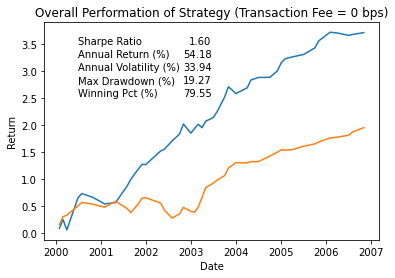

In [563]:
backtest_old(df_res_old,1,0)

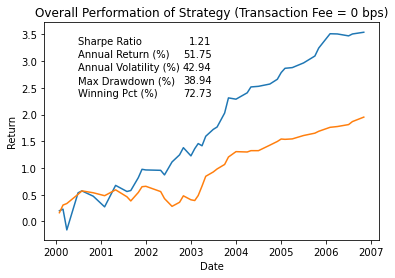

In [564]:
backtest_old(df_res_old,2,0)

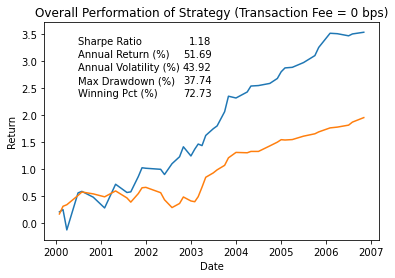

In [565]:
backtest_old(df_res_old,3,0)

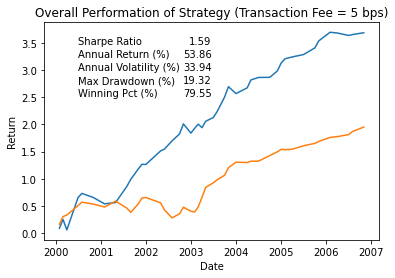

In [566]:
backtest_old(df_res_old,1,5)

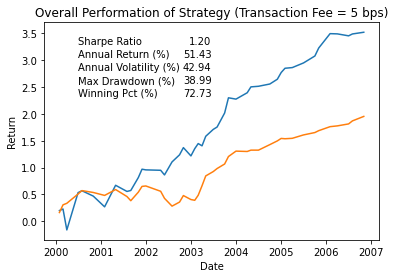

In [567]:
backtest_old(df_res_old,2,5)

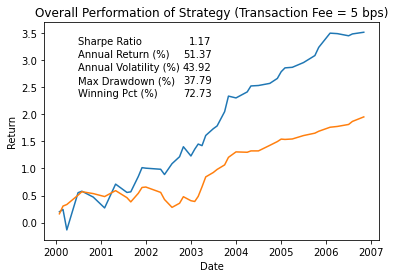

In [568]:
backtest_old(df_res_old,3,5)

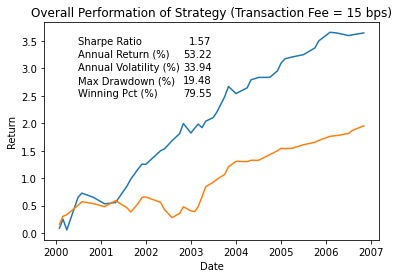

In [569]:
backtest_old(df_res_old,1,15)

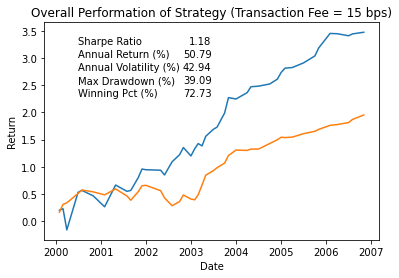

In [570]:
backtest_old(df_res_old,2,15)

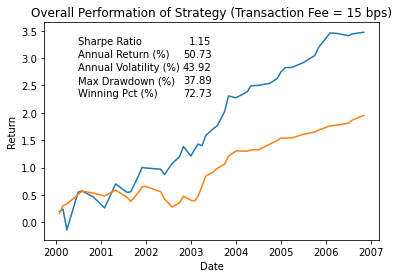

In [571]:
backtest_old(df_res_old,3,15)

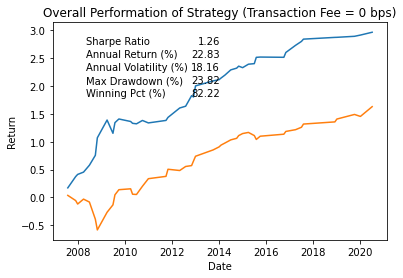

In [623]:
backtest(df_res_new,1,0)

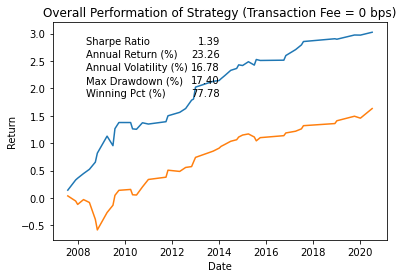

In [624]:
backtest(df_res_new,2,0)

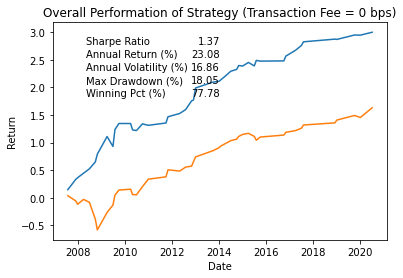

In [625]:
backtest(df_res_new,3,0)

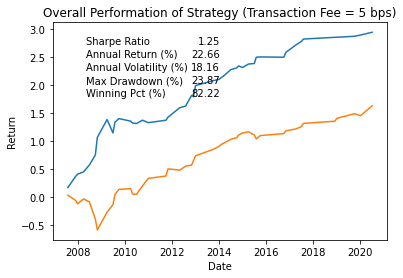

In [575]:
backtest(df_res_new,1,5)

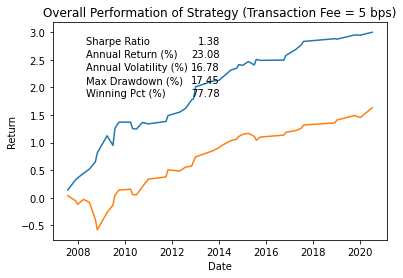

In [576]:
backtest(df_res_new,2,5)

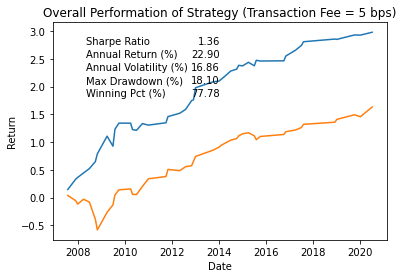

In [577]:
backtest(df_res_new,3,5)

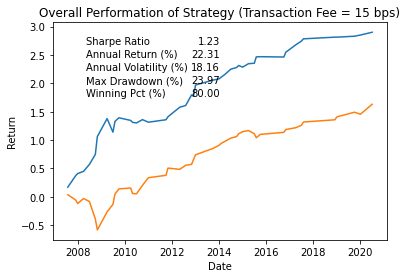

In [578]:
backtest(df_res_new,1,15)

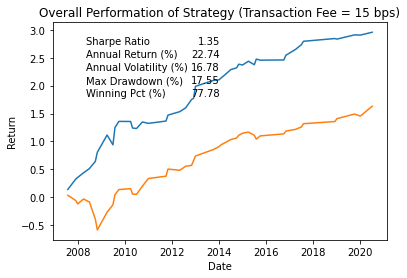

In [579]:
backtest(df_res_new,2,15)

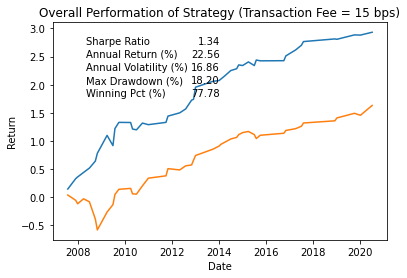

In [580]:
backtest(df_res_new,3,15)

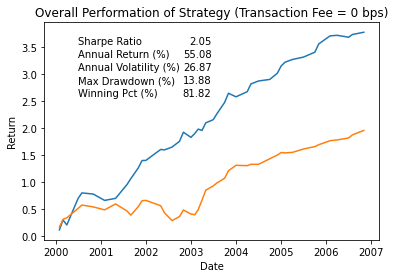

In [581]:
backtest_old(df_res10_old,1,0)

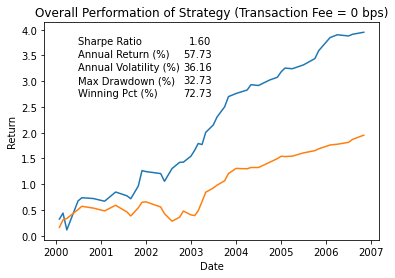

In [582]:
backtest_old(df_res10_old,2,0)

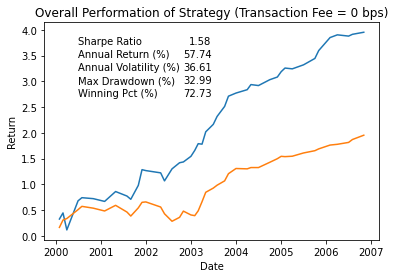

In [583]:
backtest_old(df_res10_old,3,0)

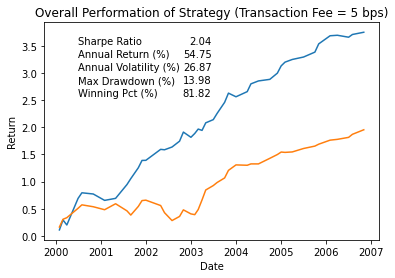

In [584]:
backtest_old(df_res10_old,1,5)

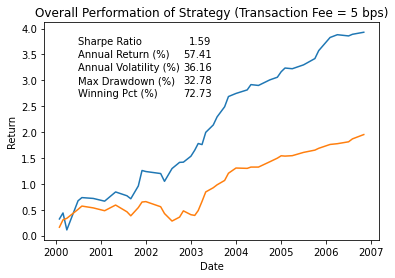

In [585]:
backtest_old(df_res10_old,2,5)

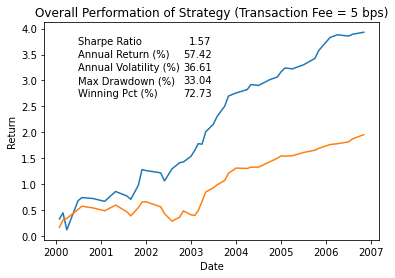

In [586]:
backtest_old(df_res10_old,3,5)

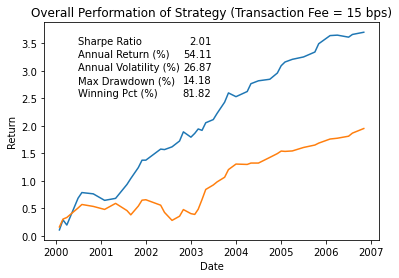

In [587]:
backtest_old(df_res10_old,1,15)

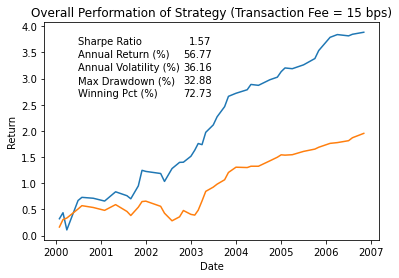

In [588]:
backtest_old(df_res10_old,2,15)

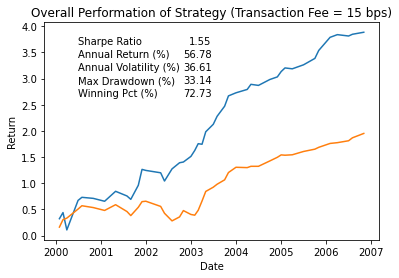

In [589]:
backtest_old(df_res10_old,3,15)

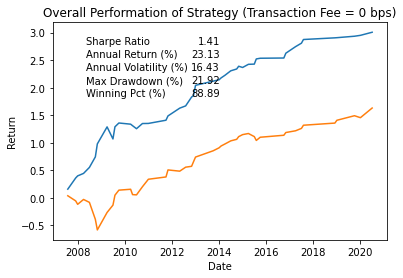

In [590]:
backtest(df_res10_new,1,0)

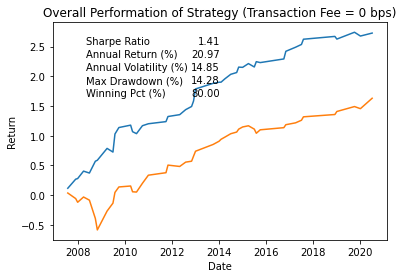

In [591]:
backtest(df_res10_new,2,0)

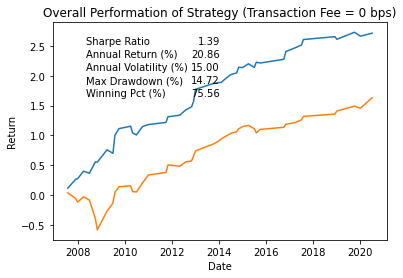

In [592]:
backtest(df_res10_new,3,0)

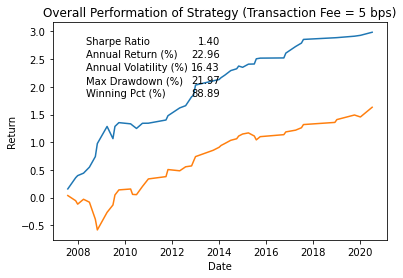

In [593]:
backtest(df_res10_new,1,5)

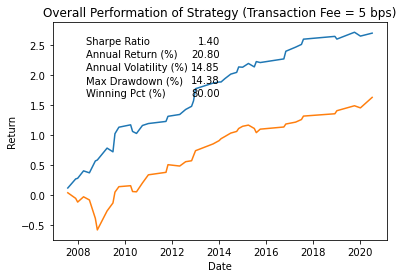

In [594]:
backtest(df_res10_new,2,5)

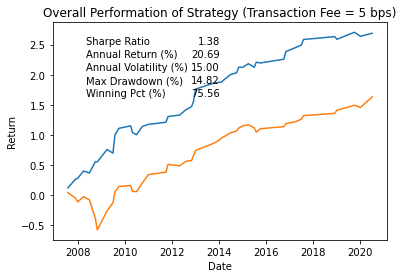

In [595]:
backtest(df_res10_new,3,5)

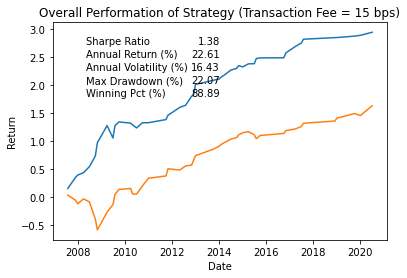

In [596]:
backtest(df_res10_new,1,15)

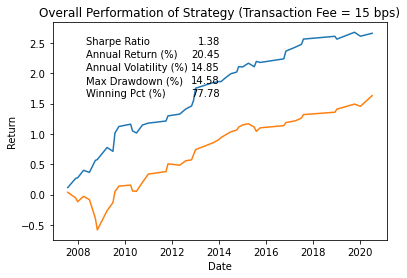

In [597]:
backtest(df_res10_new,2,15)

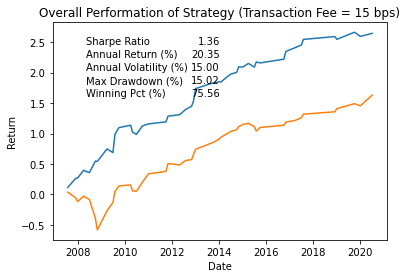

In [598]:
backtest(df_res10_new,3,15)

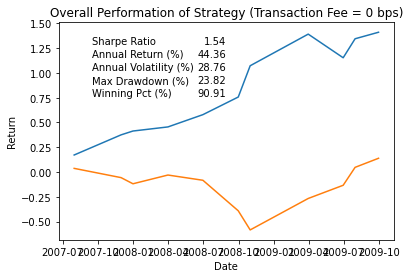

In [599]:
backtest(df_res[(df_res["date"] > datetime.date(2007,1,2)) & (df_res["date"] < datetime.date(2010,1,2))],1,0)

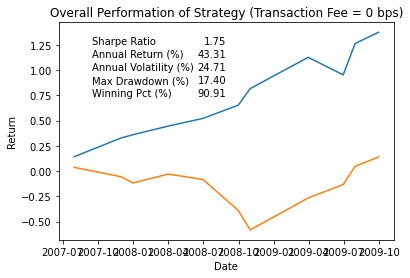

In [600]:
backtest(df_res[(df_res["date"] > datetime.date(2007,1,2)) & (df_res["date"] < datetime.date(2010,1,2))],2,0)

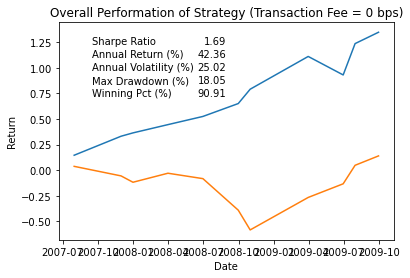

In [601]:
backtest(df_res[(df_res["date"] > datetime.date(2007,1,2)) & (df_res["date"] < datetime.date(2010,1,2))],3,0)

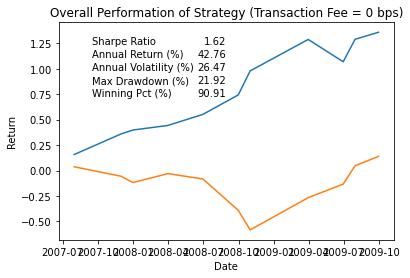

In [602]:
backtest(df_res10[(df_res10["date"] > datetime.date(2007,1,2)) & (df_res10["date"] < datetime.date(2010,1,2))],1,0)

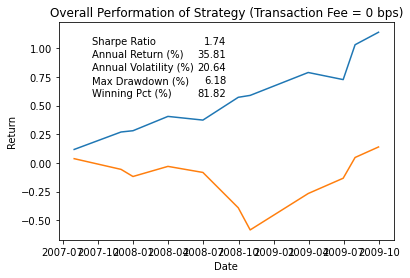

In [603]:
backtest(df_res10[(df_res10["date"] > datetime.date(2007,1,2)) & (df_res10["date"] < datetime.date(2010,1,2))],2,0)

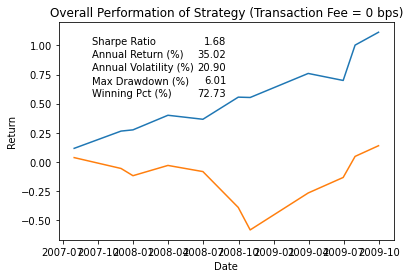

In [604]:
backtest(df_res10[(df_res10["date"] > datetime.date(2007,1,2)) & (df_res10["date"] < datetime.date(2010,1,2))],3,0)

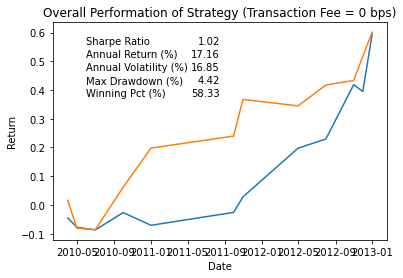

In [605]:
backtest(df_res[(df_res["date"] > datetime.date(2010,1,2)) & (df_res["date"] < datetime.date(2013,1,2))],1,0)

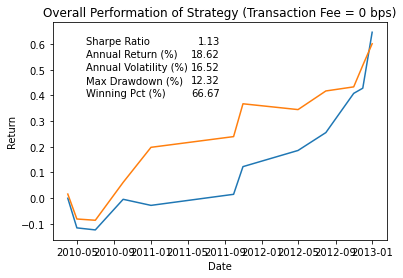

In [606]:
backtest(df_res[(df_res["date"] > datetime.date(2010,1,2)) & (df_res["date"] < datetime.date(2013,1,2))],2,0)

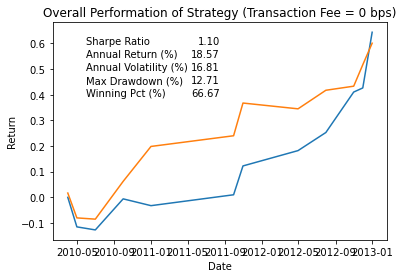

In [607]:
backtest(df_res[(df_res["date"] > datetime.date(2010,1,2)) & (df_res["date"] < datetime.date(2013,1,2))],3,0)

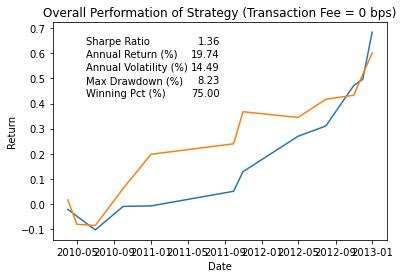

In [608]:
backtest(df_res10[(df_res10["date"] > datetime.date(2010,1,2)) & (df_res10["date"] < datetime.date(2013,1,2))],1,0)

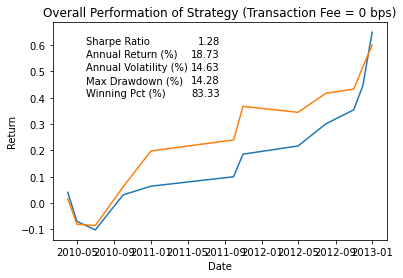

In [609]:
backtest(df_res10[(df_res10["date"] > datetime.date(2010,1,2)) & (df_res10["date"] < datetime.date(2013,1,2))],2,0)

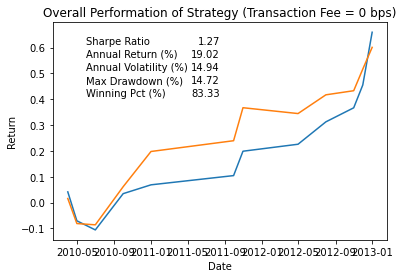

In [610]:
backtest(df_res10[(df_res10["date"] > datetime.date(2010,1,2)) & (df_res10["date"] < datetime.date(2013,1,2))],3,0)

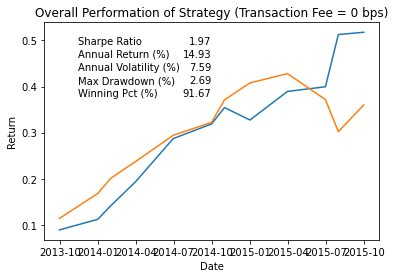

In [611]:
backtest(df_res[(df_res["date"] > datetime.date(2013,1,2)) & (df_res["date"] < datetime.date(2016,1,2))],1,0)

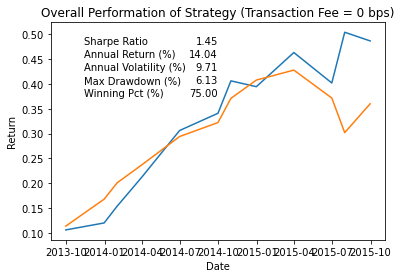

In [612]:
backtest(df_res[(df_res["date"] > datetime.date(2013,1,2)) & (df_res["date"] < datetime.date(2016,1,2))],2,0)

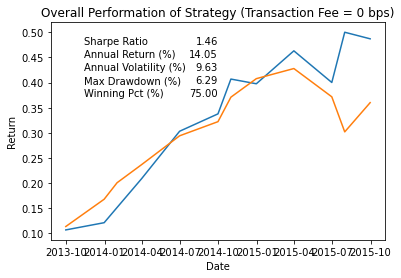

In [613]:
backtest(df_res[(df_res["date"] > datetime.date(2013,1,2)) & (df_res["date"] < datetime.date(2016,1,2))],3,0)

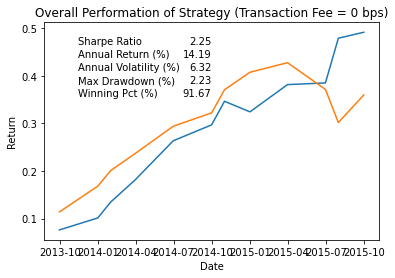

In [614]:
backtest(df_res10[(df_res10["date"] > datetime.date(2013,1,2)) & (df_res10["date"] < datetime.date(2016,1,2))],1,0)

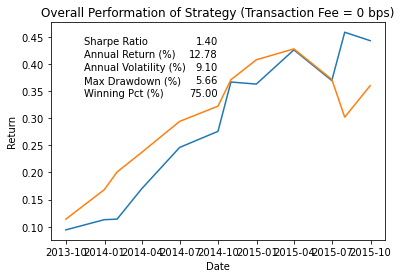

In [615]:
backtest(df_res10[(df_res10["date"] > datetime.date(2013,1,2)) & (df_res10["date"] < datetime.date(2016,1,2))],2,0)

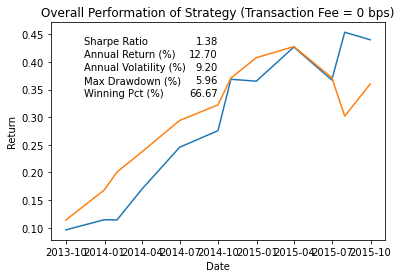

In [616]:
backtest(df_res10[(df_res10["date"] > datetime.date(2013,1,2)) & (df_res10["date"] < datetime.date(2016,1,2))],3,0)

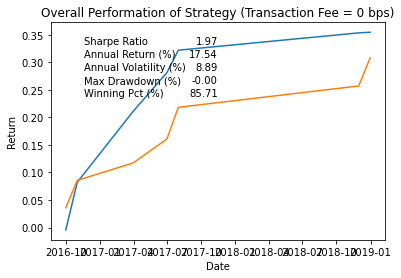

In [617]:
backtest(df_res[(df_res["date"] > datetime.date(2016,1,2)) & (df_res["date"] < datetime.date(2019,1,2))],1,0)

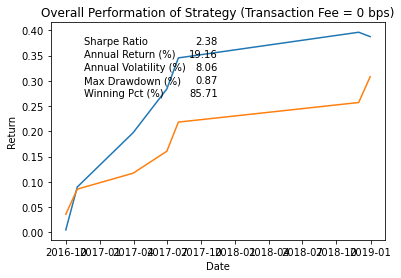

In [618]:
backtest(df_res[(df_res["date"] > datetime.date(2016,1,2)) & (df_res["date"] < datetime.date(2019,1,2))],2,0)

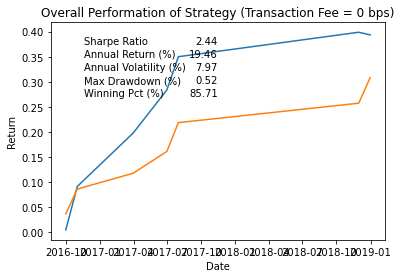

In [619]:
backtest(df_res[(df_res["date"] > datetime.date(2016,1,2)) & (df_res["date"] < datetime.date(2019,1,2))],3,0)

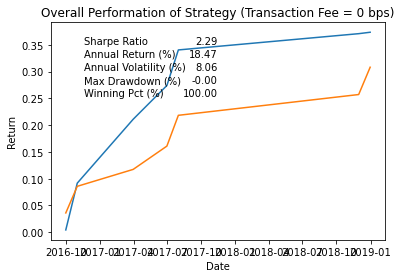

In [620]:
backtest(df_res10[(df_res10["date"] > datetime.date(2016,1,2)) & (df_res10["date"] < datetime.date(2019,1,2))],1,0)

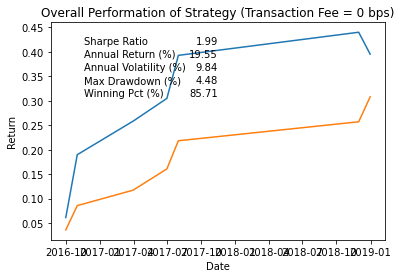

In [621]:
backtest(df_res10[(df_res10["date"] > datetime.date(2016,1,2)) & (df_res10["date"] < datetime.date(2019,1,2))],2,0)

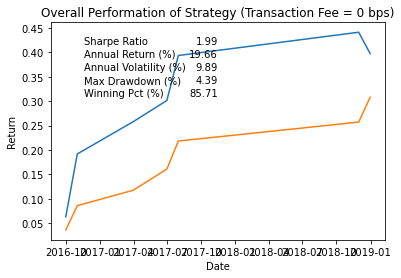

In [622]:
backtest(df_res10[(df_res10["date"] > datetime.date(2016,1,2)) & (df_res10["date"] < datetime.date(2019,1,2))],3,0)

In [337]:
df_surprise.columns

Index(['ticker', 'cusip', 'statpers', 'measure', 'numest', 'medest', 'meanest',
       'stdev', 'fpedats', 'actual', 'anndats_act', 'surprise', 'prc',
       'cfacpr', 'shrout', 'cfacshr', 'adjust_prc', 'cfacpr', 'shrout',
       'adjust_shares', 'cfacshr', 'Beta', 'Mon', 'exp_return',
       'market_return'],
      dtype='object')

In [162]:
df_res["Ret1"].sum()

6.676185799099879

In [163]:
df_res["Ret2"].sum()

6.564661164804925

In [164]:
df_res["Ret3"].sum()

6.537485725261677

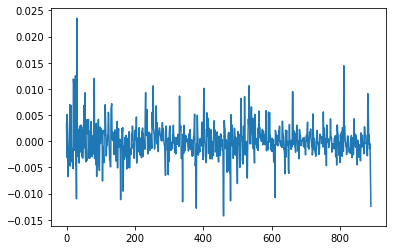

In [86]:
plt.plot(df_test["signal2"]-df_test["signal3"])

In [80]:
res1.params[0]

0.09463826198222305

In [87]:
df_test.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal2"]).sum()/x["signal2"].sum())

fpedats
2000-01-31    0.438005
2000-02-29   -2.264868
2000-03-31   -0.841005
2000-06-30    0.967698
2000-07-31    0.116819
                ...   
2018-11-30   -3.784323
2018-12-31    0.027866
2019-09-30    0.793958
2019-12-31   -0.006925
2020-06-30    0.181263
Length: 89, dtype: float64

In [88]:
df_test.groupby(["fpedats"]).apply(lambda x: (x["exp_return"]*x["signal3"]).sum()/x["signal3"].sum())

fpedats
2000-01-31    0.355830
2000-02-29    0.774281
2000-03-31   -0.799559
2000-06-30    0.956623
2000-07-31    0.080480
                ...   
2018-11-30   -4.065963
2018-12-31    0.019219
2019-09-30    0.699441
2019-12-31   -0.007872
2020-06-30    0.171015
Length: 89, dtype: float64

In [102]:
df_try = df_test[df_test["fpedats"] == datetime.date(2000,2,29)]
df_try = df_try[["fpedats","surprise","Beta","Mon","signal2","signal3", "exp_return"]]
df_try

,fpedats,surprise,Beta,Mon,signal2,signal3,exp_return
10,2000-02-29,0.1900,-0.135416,0.765706,0.045716,0.038740,0.129331
11,2000-02-29,0.0800,0.571623,-0.600126,-0.012209,-0.007463,0.458300
12,2000-02-29,0.0600,-1.114865,-0.308163,-0.010402,-0.008088,0.027551
13,2000-02-29,0.0350,-0.229461,0.807614,0.032201,0.025375,0.227259
14,2000-02-29,0.0300,0.029935,-0.038224,0.001552,0.001773,0.101780
15,2000-02-29,0.0000,1.848846,-0.460062,-0.009231,-0.005331,0.293751
16,2000-02-29,0.0000,-1.114865,-0.308163,-0.016080,-0.013572,0.027551
17,2000-02-29,-0.0011,2.011908,-0.321100,-0.003512,-0.000755,-0.087742
18,2000-02-29,-0.0103,1.742981,-0.157046,0.000550,0.001964,-0.046897
19,2000-02-29,-0.0500,-0.774181,-0.615244,-0.030731,-0.025497,-0.007251


In [103]:
df_try['sum2'] = df_try["signal2"] * df_try["exp_return"]
df_try['sum3'] = df_try["signal3"] * df_try["exp_return"]

In [104]:
df_try['sum2'].sum()/df_try["signal2"].sum()

-2.26486806527695

In [105]:
df_try['sum3'].sum()/df_try["signal3"].sum()

0.7742810515841775

In [87]:
df1 = df_crspm[df_crspm["cusip"] == "60659230"]
df1 = df1.reset_index(drop = True)
df1

,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,60659230,1998-01-30,27.0000,26.2500,28.5000,10026.0,-0.072961,26.9375,27.1250,NaN,27.0000,1.0,26934.0,26934.0,1.0
1,60659230,1998-02-27,27.4375,26.7500,28.1250,9903.0,0.016204,27.3125,27.5000,NaN,27.4375,1.0,26934.0,26934.0,1.0
2,60659230,1998-03-31,26.5000,26.0000,28.1875,7078.0,-0.029339,26.7500,27.0000,NaN,26.5000,1.0,26934.0,26934.0,1.0
3,60659230,1998-04-30,25.2500,24.7500,27.1250,4748.0,-0.047170,24.8750,25.5625,NaN,25.2500,1.0,26880.0,26880.0,1.0
4,60659230,1998-05-29,23.1250,22.8750,25.3750,8669.0,-0.084158,22.8125,23.1875,NaN,23.1250,1.0,26880.0,26880.0,1.0
5,60659230,1998-06-30,19.2500,19.2500,23.1250,8086.0,-0.161838,19.0000,19.5000,NaN,19.2500,1.0,26794.0,26794.0,1.0
6,60659230,1998-07-31,18.0000,18.0000,20.5000,7369.0,-0.064935,17.8750,18.1875,NaN,18.0000,1.0,26794.0,26794.0,1.0
7,60659230,1998-08-31,14.0000,14.0000,17.7500,10393.0,-0.222222,13.9375,14.5625,NaN,14.0000,1.0,26794.0,26794.0,1.0
8,60659230,1998-09-30,14.0000,13.1250,14.2500,9608.0,0.009464,13.8125,14.0625,NaN,14.0000,1.0,26795.0,26795.0,1.0
9,60659230,1998-10-30,14.0625,12.3750,14.0625,10409.0,0.004464,13.8750,14.1875,NaN,14.0625,1.0,26795.0,26795.0,1.0


In [88]:
n = df1.index[df1['date']==datetime.date(2000,1,31)][0]

In [89]:
df1 = df1[n-11:n+1].reset_index(drop = True)

In [90]:
df1

,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,60659230,1999-02-26,12.2500,11.7500,12.7500,3306.0,-0.029703,12.0625,12.3125,NaN,12.2500,1.0,26796.0,26796.0,1.0
1,60659230,1999-03-31,12.5000,12.2500,14.8750,8202.0,0.031224,12.3750,12.6250,NaN,12.5000,1.0,26796.0,26796.0,1.0
2,60659230,1999-04-30,15.3750,13.6875,15.5000,7603.0,0.230000,15.0625,15.5625,NaN,15.3750,1.0,26796.0,26796.0,1.0
3,60659230,1999-05-28,16.1250,15.9375,16.5000,7796.0,0.048780,16.0625,16.3125,NaN,16.1250,1.0,26796.0,26796.0,1.0
4,60659230,1999-06-30,18.3750,16.0000,18.5000,4953.0,0.147752,18.6875,18.8125,NaN,18.3750,1.0,26796.0,26796.0,1.0
5,60659230,1999-07-30,17.5000,17.5000,18.5625,6541.0,-0.047619,17.3125,17.6875,NaN,17.5000,1.0,26796.0,26796.0,1.0
6,60659230,1999-08-31,19.7500,17.3125,20.0000,7496.0,0.128571,19.4375,20.1875,NaN,19.7500,1.0,26796.0,26796.0,1.0
7,60659230,1999-09-30,23.5000,19.5000,23.5000,7352.0,0.196582,23.1875,23.6250,NaN,23.5000,1.0,26796.0,26796.0,1.0
8,60659230,1999-10-29,23.8125,21.8750,24.5000,8160.0,0.013298,23.6250,24.0000,NaN,23.8125,1.0,26796.0,26796.0,1.0
9,60659230,1999-11-30,23.0000,23.0000,24.3125,4390.0,-0.034121,22.7500,23.2500,NaN,23.0000,1.0,26796.0,26796.0,1.0


In [59]:
ret_lst = df1["ret"].to_list()
ret_lst

[-0.02970297075808048,
 0.03122448921203613,
 0.2300000041723251,
 0.04878048598766327,
 0.1477519422769547,
 -0.0476190485060215,
 0.1285714358091354,
 0.1965822726488113,
 0.01329787261784077,
 -0.03412073478102684,
 -0.05673912912607193,
 0.04347826167941093,
 -0.06388889253139496,
 0.05082492530345917,
 0.08806817978620529]

In [64]:
ret = sum(ret_lst[12:])
ret

0.0750042125582695

In [67]:
n1 = df_m_ret.index[df_m_ret['date']==datetime.date(2000,1,31)][0]
df2 = df_m_ret

In [68]:
df2 = df2[n1-11:n1+4]

In [69]:
retm_lst = df2["ret"].to_list()
retm_lst

[-0.0281,
 0.0571,
 0.0691,
 -0.012,
 0.0624,
 -0.0208,
 0.0011,
 -0.0091,
 0.0801,
 0.0591,
 0.129,
 -0.0143,
 0.0956,
 0.0816,
 -0.0344]

In [91]:
np.cov(retm_lst,ret_lst)[0][0]

0.0028097792380952376

In [71]:
np.var(retm_lst)

0.0026224606222222226

In [79]:
df1 = df1.reset_index(drop = True)

In [80]:
df1

,level_0,index,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,13,123147,60659230,1999-02-26,12.2500,11.7500,12.7500,3306.0,-0.029703,12.0625,12.3125,NaN,12.2500,1.0,26796.0,26796.0,1.0
1,14,131981,60659230,1999-03-31,12.5000,12.2500,14.8750,8202.0,0.031224,12.3750,12.6250,NaN,12.5000,1.0,26796.0,26796.0,1.0
2,15,140787,60659230,1999-04-30,15.3750,13.6875,15.5000,7603.0,0.230000,15.0625,15.5625,NaN,15.3750,1.0,26796.0,26796.0,1.0
3,16,149555,60659230,1999-05-28,16.1250,15.9375,16.5000,7796.0,0.048780,16.0625,16.3125,NaN,16.1250,1.0,26796.0,26796.0,1.0
4,17,158312,60659230,1999-06-30,18.3750,16.0000,18.5000,4953.0,0.147752,18.6875,18.8125,NaN,18.3750,1.0,26796.0,26796.0,1.0
5,18,167064,60659230,1999-07-30,17.5000,17.5000,18.5625,6541.0,-0.047619,17.3125,17.6875,NaN,17.5000,1.0,26796.0,26796.0,1.0
6,19,175798,60659230,1999-08-31,19.7500,17.3125,20.0000,7496.0,0.128571,19.4375,20.1875,NaN,19.7500,1.0,26796.0,26796.0,1.0
7,20,184496,60659230,1999-09-30,23.5000,19.5000,23.5000,7352.0,0.196582,23.1875,23.6250,NaN,23.5000,1.0,26796.0,26796.0,1.0
8,21,193183,60659230,1999-10-29,23.8125,21.8750,24.5000,8160.0,0.013298,23.6250,24.0000,NaN,23.8125,1.0,26796.0,26796.0,1.0
9,22,201878,60659230,1999-11-30,23.0000,23.0000,24.3125,4390.0,-0.034121,22.7500,23.2500,NaN,23.0000,1.0,26796.0,26796.0,1.0


In [78]:
df1["date"].iloc[1]

datetime.date(1999, 3, 31)

In [92]:
np.cov(retm_lst,ret_lst)[0][1]

-0.000935311313968684

In [93]:
np.cov(retm_lst,ret_lst)

array([[ 0.00280978, -0.00093531],
       [-0.00093531,  0.00858073]])

In [94]:
df_m_ret 

,date,ret
0,1925-12-31,NaN
1,1926-01-30,0.0053
2,1926-02-27,-0.0307
3,1926-03-31,-0.0580
4,1926-04-30,0.0407
...,...,...
1136,2020-08-31,0.0772
1137,2020-09-30,-0.0291
1138,2020-10-30,-0.0138
1139,2020-11-30,0.1360


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 0

In [116]:
np.nan

nan

In [176]:
db.raw_sql(f"""SELECT cusip,date,prc,bidlo,askhi,vol, ret, bid, ask, spread,CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM crsp.msf where date='1998-01-30' limit 10 ;""")

,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,36720410,1998-01-30,9.0000,8.7500,9.1250,684.0,0.000000,8.7500,9.0000,NaN,6.0000,1.5,2395.0,3592.5,1.5
1,05978R10,1998-01-30,25.0000,21.0000,28.0000,202.0,0.020408,25.2500,28.0000,NaN,16.6667,1.5,4246.0,6369.0,1.5
2,46334710,1998-01-30,-25.3750,25.0000,27.0000,209.0,-0.014563,25.0000,25.7500,0.75,-25.3750,1.0,2389.0,2389.0,1.0
3,00206710,1998-01-30,11.9375,11.6250,12.0000,3641.0,0.026882,11.9375,12.0000,NaN,11.9375,1.0,7930.0,7930.0,1.0
4,23326910,1998-01-30,3.7500,3.4375,4.6250,18438.0,-0.189189,3.6875,3.8125,NaN,3.7500,1.0,17501.0,17501.0,1.0
5,81002230,1998-01-30,13.2500,12.5000,13.8125,7677.0,0.009524,12.9375,13.2500,NaN,13.2500,1.0,13729.0,13729.0,1.0
6,44950710,1998-01-30,16.1250,14.2500,17.5000,12633.0,0.040323,16.1250,17.0000,NaN,16.1250,1.0,8205.0,8205.0,1.0
7,00103110,1998-01-30,33.5000,30.0000,33.7500,2075.0,0.085020,32.5000,34.0000,NaN,33.5000,1.0,7219.0,7219.0,1.0
8,46603210,1998-01-30,14.2500,12.7500,16.3750,4884.0,-0.129771,14.2500,14.5000,NaN,7.1250,2.0,8872.0,17744.0,2.0
9,29402E10,1998-01-30,2.8125,2.6250,3.2500,342.0,0.022727,2.6875,2.9375,NaN,2.8125,1.0,4338.0,4338.0,1.0


In [188]:
db.raw_sql(f"""
select * from (
SELECT cusip,date,prc,bidlo,askhi,vol, ret, bid, ask, spread,CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM crsp.msf where date>'1988-01-30'  
) as a
where adjust_shares*adjust_prc>500000
""")

,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,86681020,1988-02-29,32.750000,29.750000,35.500000,134980.0,-0.022388,32.500000,32.750000,None,2.0469,16.000000,34409.0,550544.0,16.0
1,68389X10,1988-02-29,15.125000,12.250000,15.500000,62892.0,0.080357,15.000000,15.250000,None,0.1867,81.000000,59646.0,4831326.0,81.0
2,59491810,1988-02-29,59.375000,51.000000,59.875000,97635.0,0.065022,59.250000,59.500000,None,0.4123,144.000000,53239.0,7666416.0,144.0
3,01736110,1988-02-29,39.000000,39.000000,41.500000,12905.0,-0.037037,NaN,NaN,None,19.5000,2.000000,51327.0,102654.0,2.0
4,43851610,1988-02-29,32.500000,31.375000,33.375000,106714.0,0.054400,NaN,NaN,None,7.7545,4.191136,151131.0,604524.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397780,74733V10,2020-12-31,2.390000,1.580000,2.440000,1707010.0,0.484472,2.380000,2.390000,None,2.3900,1.000000,242936.0,242936.0,1.0
397781,83001A10,2020-12-31,34.099998,31.150000,34.310001,341364.0,0.109665,34.099998,34.110001,None,34.1000,1.000000,84977.0,84977.0,1.0
397782,G3323L10,2020-12-31,77.589996,68.389999,77.860001,40249.0,0.135851,77.589996,77.620003,None,77.5900,1.000000,36938.0,36938.0,1.0
397783,12503M10,2020-12-31,93.120003,85.970001,93.730003,167295.0,0.019711,92.940002,93.120003,None,93.1200,1.000000,108042.0,108042.0,1.0


In [185]:
db.raw_sql(f"""
select * from (
SELECT cusip,date,prc,bidlo,askhi,vol, ret, bid, ask, spread,CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM crsp.msf where date>'1988-01-30'  
) as a
""")

,cusip,date,prc,bidlo,askhi,vol,ret,bid,ask,spread,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,36720410,1988-02-29,6.750000,6.250000,6.750000,382.0,0.080000,6.250000,6.750000,NaN,2.2500,3.0,992.0,2976.0,3.0
1,36720410,1988-03-31,6.125000,6.125000,6.625000,369.0,-0.076296,6.125000,6.625000,NaN,2.0417,3.0,992.0,2976.0,3.0
2,36720410,1988-04-29,-6.312500,6.125000,6.625000,121.0,0.030612,6.125000,6.500000,0.375,-2.1042,3.0,992.0,2976.0,3.0
3,36720410,1988-05-31,-6.437500,6.125000,6.625000,102.0,0.019802,6.250000,6.625000,0.375,-2.1458,3.0,992.0,2976.0,3.0
4,36720410,1988-06-30,6.250000,6.250000,6.750000,153.0,-0.012039,6.250000,6.750000,NaN,2.0833,3.0,992.0,2976.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471752,88160R10,2020-08-31,498.320007,498.320007,2238.750000,4051970.0,0.741452,498.279999,498.510010,NaN,498.3200,1.0,931809.0,931809.0,1.0
471753,88160R10,2020-09-30,429.010010,330.209991,475.049988,17331954.0,-0.139087,428.820007,429.019989,NaN,429.0100,1.0,948000.0,948000.0,1.0
471754,88160R10,2020-10-30,388.040009,388.040009,461.299988,8330610.0,-0.095499,388.040009,388.350006,NaN,388.0400,1.0,947901.0,947901.0,1.0
471755,88160R10,2020-11-30,567.599976,400.510010,585.760010,7811501.0,0.462736,566.099976,566.859985,NaN,567.5999,1.0,947901.0,947901.0,1.0


In [193]:
db.raw_sql(f"""
select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
from (
SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
) as a
 inner join (
SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
FROM ibes.statsum_epsus as a,crsp.msf as b 

where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
)

) as b
on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
;
""")

,ticker,cusip,statpers,measure,numest,medest,meanest,stdev,fpedats,actual,anndats_act,surprise,prc,cfacpr,shrout,cfacshr
0,A,02742010,1983-12-15,EPS,1.0,2.47,2.47,NaN,1984-12-31,-0.360,None,-2.830,1.187500,1.0,6754.0,1.0
1,A,02742010,1986-12-18,EPS,1.0,0.30,0.30,NaN,1986-12-31,-0.300,None,-0.600,3.375000,1.0,7939.0,1.0
2,A,02742010,1986-12-18,EPS,1.0,0.75,0.75,NaN,1987-12-31,-0.280,None,-1.030,1.750000,1.0,12918.0,1.0
3,AAC,03237510,1990-02-15,EPS,1.0,0.25,0.25,NaN,1990-12-31,0.140,1991-02-08,-0.110,1.750000,1.0,37580.0,1.0
4,AACE,00440310,1999-12-16,EPS,2.0,0.13,0.13,0.00,1999-12-31,0.140,2000-01-20,0.010,18.500000,1.0,10064.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45149,ZY,87254010,2015-07-16,EPS,25.0,0.37,0.38,0.01,2015-07-31,0.400,2015-08-18,0.020,69.820000,2.0,680385.0,2.0
45150,ZY,87254010,2016-10-20,EPS,27.0,0.43,0.43,0.01,2016-10-31,0.455,2016-11-15,0.025,73.750000,2.0,656645.0,2.0
45151,ZY,87254010,2017-07-20,EPS,25.0,0.42,0.42,0.01,2017-07-31,0.425,2017-08-15,0.005,70.309998,2.0,643276.0,2.0
45152,ZY,87254010,2017-10-19,EPS,26.0,0.50,0.50,0.01,2017-10-31,0.500,2017-11-14,0.000,69.800003,2.0,636274.0,2.0


In [195]:
db.raw_sql(f"""

SELECT b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr , CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM 
(
select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
from (
SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
) as a
 inner join (
SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
FROM ibes.statsum_epsus as a,crsp.msf as b 

where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
)

) as b
on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
) as b

""")

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "adjust_shares" does not exist
LINE 21: where adjust_shares*adjust_prc>500000
               ^

[SQL: 

SELECT b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr , CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM 
(
select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
from (
SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
) as a
 inner join (
SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
FROM ibes.statsum_epsus as a,crsp.msf as b 

where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
)

) as b
on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
) as b
where adjust_shares*adjust_prc>500000
]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [196]:
db.raw_sql(f"""
select * from (
SELECT b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr , CAST(prc/(cfacpr+0.0000001) as decimal(38, 4))  as adjust_prc,cfacpr,shrout,shrout*cfacshr as adjust_shares ,cfacshr FROM 
(
select b.ticker,b.cusip,b.statpers,b.measure,b.numest,b.medest,b.meanest,b.stdev,b.fpedats,b.actual,b.anndats_act,b.surprise,b.prc,b.cfacpr,b.shrout,b.cfacshr
from (
SELECT  cusip,max(statpers) as statpers,fpedats FROM ibes.statsum_epsus group by cusip,fpedats
) as a
 inner join (
SELECT a.ticker, a.cusip, a.statpers,a.measure,a.numest,a.medest,a.meanest,a.stdev,a.fpedats,a.actual,
a.anndats_act,a.actual - a.meanest as surprise, (a.actual - a.meanest)/abs(b.prc) as surprise_percent,b.prc,b.cfacpr,b.shrout,b.cfacshr
FROM ibes.statsum_epsus as a,crsp.msf as b 

where a.cusip=b.cusip and a.fpedats=b.date and statpers< fpedats and a.cusip in (
SELECT distinct cusip FROM ibes.statsum_epsus WHERE statpers<'2001-01-01'
)

) as b
on a.cusip=b.cusip and a.statpers=b.statpers and a.fpedats=b.fpedats
) as b
) as b
where adjust_shares*adjust_prc>500000
""")

,ticker,cusip,statpers,measure,numest,medest,meanest,stdev,fpedats,actual,...,surprise,prc,cfacpr,shrout,cfacshr,adjust_prc,cfacpr,shrout,adjust_shares,cfacshr
0,AAIC,01234810,1995-06-15,EPS,7.0,0.31,0.31,0.02,1995-06-30,0.3616,...,0.0516,23.875000,1.05083,24345.0,1.05083,22.7201,1.05083,24345.0,2.558246e+04,1.05083
1,AAIC,01234810,1997-03-20,EPS,5.0,0.33,0.33,0.00,1997-03-31,0.3426,...,0.0126,20.625000,1.05083,24796.0,1.05083,19.6273,1.05083,24796.0,2.605638e+04,1.05083
2,ABBY,03793310,2000-06-15,EPS,4.0,0.24,0.24,0.01,2000-06-30,0.2600,...,0.0200,12.250000,1.00000,52365.0,1.00000,12.2500,1.00000,52365.0,5.236500e+04,1.00000
3,ABC,02473510,1985-09-19,EPS,10.0,1.40,1.53,0.59,1985-09-30,1.0200,...,-0.5100,115.250000,1.00000,28654.0,1.00000,115.2500,1.00000,28654.0,2.865400e+04,1.00000
4,AAPL,03783310,1985-09-19,EPS,27.0,0.00,0.00,0.00,1985-09-30,0.0045,...,0.0045,15.750000,224.00000,61850.0,224.00000,0.0703,224.00000,61850.0,1.385440e+07,224.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19071,ZY,87254010,2012-10-18,EPS,21.0,0.30,0.31,0.01,2012-10-31,0.3100,...,0.0000,41.630001,2.00000,736100.0,2.00000,20.8150,2.00000,736100.0,1.472200e+06,2.00000
19072,ZY,87254010,2017-07-20,EPS,25.0,0.42,0.42,0.01,2017-07-31,0.4250,...,0.0050,70.309998,2.00000,643276.0,2.00000,35.1550,2.00000,643276.0,1.286552e+06,2.00000
19073,ZY,87254010,2016-10-20,EPS,27.0,0.43,0.43,0.01,2016-10-31,0.4550,...,0.0250,73.750000,2.00000,656645.0,2.00000,36.8750,2.00000,656645.0,1.313290e+06,2.00000
19074,ZY,87254010,2017-10-19,EPS,26.0,0.50,0.50,0.01,2017-10-31,0.5000,...,0.0000,69.800003,2.00000,636274.0,2.00000,34.9000,2.00000,636274.0,1.272548e+06,2.00000
